In [6]:
%load_ext autoreload
%autoreload 2
from pathlib import Path
import numpy as np
import pandas as pd

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# 0. Check LFW embeddings

In [27]:
dataset_path = '/app/datasets/lfw/data_aligned_112_112'
img_names = np.array([str(x) for x in list(Path(dataset_path).rglob("*.jpg"))])
embs = np.load('/app/cache/features/scf_embs_lfw.npz')['embs']

In [43]:
from tqdm import tqdm
# load pairs
pairs_path = '/app/datasets/lfw/pairs_val_6000.txt'
pairs_label = []
pairs_score = []
with open(pairs_path) as fd:
    for line in tqdm(fd):
        pair_data = line[:-1].split('\t')
        # assert len(pair_data) == 3 or len(pair_data) == 4
        if len(pair_data) == 3:
            first_image_path = Path(dataset_path) / pair_data[0] / f'{pair_data[0]}_{pair_data[1].zfill(4)}.jpg'
            second_image_path = Path(dataset_path) / pair_data[0] / f'{pair_data[0]}_{pair_data[2].zfill(4)}.jpg'
            pairs_label.append(1)
        else:
            first_image_path = Path(dataset_path) / pair_data[0] / f'{pair_data[0]}_{pair_data[1].zfill(4)}.jpg'
            second_image_path = Path(dataset_path) / pair_data[2] / f'{pair_data[2]}_{pair_data[3].zfill(4)}.jpg'
            pairs_label.append(0)
        pairs_score.append(embs[img_names == str(first_image_path)][0] @ embs[img_names == str(second_image_path)][0])

0it [00:00, ?it/s]

6000it [00:10, 583.32it/s]


In [48]:
pairs_score = np.array(pairs_score)
pairs_label = np.array(pairs_label)

In [51]:
import seaborn as sns
import matplotlib.pyplot as plt
def draw_score_distr_plot(
    scores_distr, score_type, model_name, in_data_name, out_data_name
):
    sns.set_theme()
    plt.figure(figsize=(12, 8))
    sns.distplot(
        scores_distr[in_data_name],
        kde=True,
        norm_hist=True,
        hist=True,
        label=in_data_name,
    )
    sns.distplot(
        scores_distr[out_data_name],
        kde=True,
        norm_hist=True,
        hist=True,
        label=out_data_name,
    )
    plt.xlabel(f"Косинусная схожесть")

    plt.legend()

/home/erlygin/miniconda/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/erlygin/miniconda/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


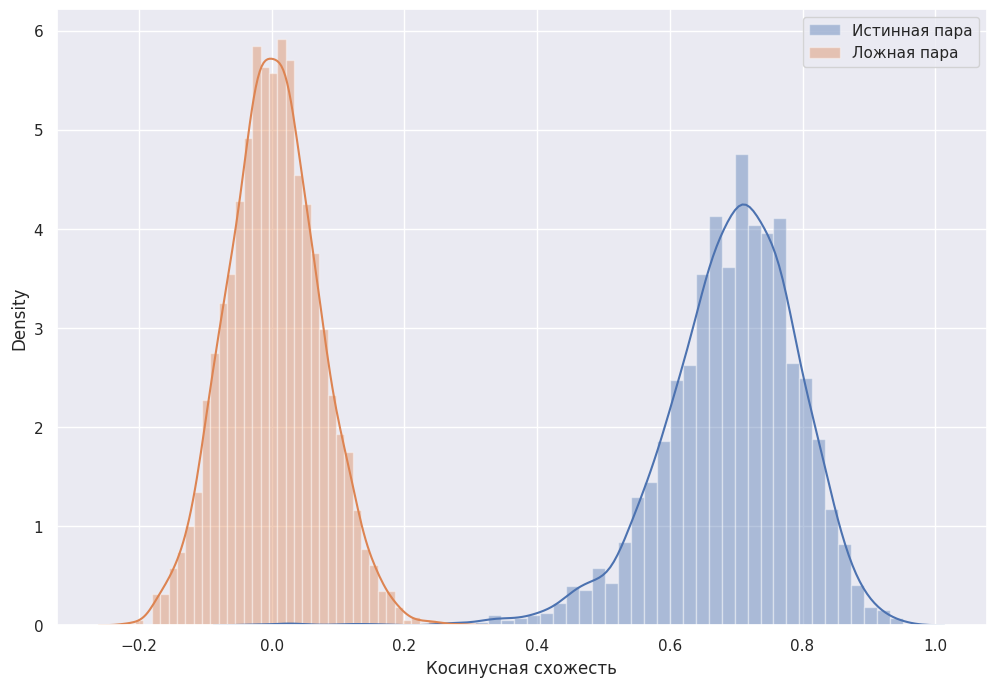

In [52]:
true_match_scores = pairs_score[pairs_label == 1]
wrong_match_scores = pairs_score[pairs_label == 0]
scores_distr = {
    "Истинная пара": true_match_scores,
    "Ложная пара": wrong_match_scores,
}

draw_score_distr_plot(
    scores_distr=scores_distr,
    score_type="EVM",
    model_name="EVM",
    in_data_name="Истинная пара",
    out_data_name="Ложная пара",
)